In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn. metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import pickle
from datetime import date
from patsy import dmatrices
import statsmodels.api as sm
from collections import defaultdict
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#import calender
from matplotlib.ticker import MaxNLocator

import jenkspy
Writer = animation.writers['pillow']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
af_to_104m3 = 0.123348

In [3]:
def DailyMean( maindf,component, month, yrs, days, monthnumber, inputyr):

    Daylist = defaultdict(list)
    DayFrame= defaultdict(list)
    timecol = ['Year', 'Month' , 'Day']

    for i in days:
        Daylist[month+ str(i)]= []
        DayFrame[month + str(i)] = pd.DataFrame(yrs, columns=['Year'])
    

    for i in yrs:
        for j in days:
            Daylist[month+str(j)].append(maindf.loc[str(i)+'-'+ monthnumber +'-'+str(j)][component])
            DayFrame[month+str(j)]['Day']=j
            DayFrame[month+str(j)]['Month'] = int(monthnumber)

    for i in DayFrame:
        DayFrame[i][component] = Daylist[i]
        
    histcomponent = 'Hist_Mean_' + component
        
    for i in DayFrame:
        DayFrame[i][histcomponent]= np.mean(DayFrame[i][component])
        del DayFrame[i]['component']
        
        ##put into year of choice
        DayFrame[i]['Year']=inputyr
        #create the date for input into figure DF
        DayFrame[i].insert(loc=0, column='Date', value=pd.to_datetime(DayFrame[i][['Year', 'Month', 'Day']]))
        DayFrame[i] = DayFrame[i].drop(columns = timecol)
        DayFrame[i]=DayFrame[i].set_index('Date')
        DayFrame[i]=DayFrame[i].iloc[0]
        DayFrame[i] = pd.DataFrame(DayFrame[i]).T
        
        
    return DayFrame

In [3]:
#Make a function to do all of the below for me so evaluate scenarios much quicker/easier


def ForecastDataPrep(DFin, DF0cons, Outyear, DellDF, simulation):
    af_to_104m3 = 0.123348
    
    #set the index to time
    DFin=DFin.set_index('Time')
    DellDF=DellDF.set_index('Time')
    
    #Use historical data, prior to WY2021
    Histyrs=DF0cons.copy()
    Histyrs=Histyrs.set_index('Time')
    Histyrs = Histyrs[:"2020-10-31"]
    
    #add info to Dell reservoir deadpool
    DellDF['Mtn_Deadpool'] = 800
    DellDF['Little_Deadpool'] = 1000
    
    #Select time of importance 2021, 2022
    DFin = DFin[DFin.index.year.isin([Outyear])].copy()
    Dell = DellDF[DellDF.index.year.isin([Outyear])].copy()
    
    #remove WY months not in WY
    #DFin = DFin[~DFin.index.month.isin([10,11,12])]
    
    #remove months that are not if interst in historical dataset
    Histyrs = Histyrs[~Histyrs.index.month.isin([1,2,3,11,12])]
    
    #convert daily outputs (AF) to 104m3
    for i in DFin:
        DFin[i]=DFin[i]*af_to_104m3
        Histyrs[i]=Histyrs[i]*af_to_104m3
    '''
    Using the historical daily DC water usage, Find the mean daily DC usage and add it to the 
    Main DF to compare 2021 and 2022 water usage.
    '''
    yrs = np.arange(2001,2021,1)
    Aprdays = np.arange(1,31,1)
    Maydays = np.arange(1,32,1)
    Jundays = np.arange(1,31,1)
    Juldays = np.arange(1,32,1)
    Augdays = np.arange(1,32,1)
    Sepdays = np.arange(1,31,1)
    Octdays = np.arange(1,32,1)

    #Set up DF for mean daily DC water usage for WY 2021
    Apr = DailyMean(Histyrs,'Apr', yrs, Aprdays, '04', Outyear)
    May = DailyMean(Histyrs,'May', yrs, Maydays, '05', Outyear)
    Jun = DailyMean(Histyrs,'Jun', yrs, Jundays, '06', Outyear)
    Jul = DailyMean(Histyrs,'Jul', yrs, Juldays, '07', Outyear)
    Aug = DailyMean(Histyrs,'Aug', yrs, Augdays, '08', Outyear)
    Sep = DailyMean(Histyrs,'Sep', yrs, Sepdays, '09', Outyear)
    Oct = DailyMean(Histyrs,'Oct', yrs, Octdays, '10', Outyear)

    DC_Mean = pd.DataFrame()
    for i in Apr:
        DC_Mean = DC_Mean.append(Apr[i])
    for i in May:
        DC_Mean = DC_Mean.append(May[i])
    for i in Jun:
        DC_Mean = DC_Mean.append(Jun[i])
    for i in Jul:
        DC_Mean = DC_Mean.append(Jul[i])
    for i in Aug:
        DC_Mean = DC_Mean.append(Aug[i])
    for i in Sep:
        DC_Mean = DC_Mean.append(Sep[i])
    for i in Oct:
        DC_Mean = DC_Mean.append(Oct[i])
    
    #create an empty column for mean delivery
    DFin['Hist_Mean_DC_Delivery'] = 0

    #Update the Output2021 with historical period daily DC usage
    DFin.update(DC_Mean)
    
    DFin['Extra_DC'] = DFin['SLCDPU_DC_Water_Use']-DFin['Hist_Mean_DC_Delivery']

    #Make negative values zero for simplicity
    DFin.loc[DFin['Extra_DC'] < 0, ['Extra_DC']] = 0
    
    #del DFin['Unnamed: 6']
    #create a DF for monthly sum of Outputs
    DFinMonthly =DFin.copy()
    HistyrsMonthly = Histyrs.copy()

    #Take the monthly sum
    DFinMonthly = DFinMonthly.resample('M').sum()
    HistyrsMonthly = HistyrsMonthly.resample('M').sum()


    #convert this one to acre feet, no need it all units are m3
   # for i in DFinMonthly:
    #    DFinMonthly[i] = DFinMonthly[i]*(1/0.2713280731353764)
        
    #for i in HistyrsMonthly:
     #   HistyrsMonthly[i] = HistyrsMonthly[i]*(1/0.2713280731353764)

    
    return DFin, DFinMonthly, Dell


In [45]:
def Sup_Dem_Figure2(DayDF, MonthDF, Dell, yr, IndoorCons, OutdoorCons, FigPath, simulation, modeltype):
    
    #need to convert MGD to m3x10^4
    #DayDF = DayDF*0.454609
   
    #need to convert Acre-Feet to 10^4m3
    #MonthDF = MonthDF*0.123348
    
    MonthDF['Month'] = MonthDF.index
    MonthDF['Month'] = pd.to_datetime(MonthDF['Month'], format='%m').dt.month_name().str.slice(stop=3)
    MonthDF.index = MonthDF['Month']
    del MonthDF['Month']
    
 
    #Reduce width to increase space between bars
    width = 1
    widthM = .95

    fig, ax = plt.subplots(2,1, constrained_layout=True)
    fig.set_size_inches(9,9)
    DayDF['ExtraDC'] = DayDF.SLCDPU_DC_Water_Use-DayDF.Hist_Mean_DC_Delivery
    
    #Daily Figure
    ax[0].bar(DayDF.index, DayDF.SLCDPU_Prod_Demands, width=width, 
        color='blue', label='Sim: '+ simulation)
    ax[0].bar(DayDF.index, DayDF.SLCDPU_DC_Water_Use, width=width, 
        color='r', label=  'DCR Request')
    ax[0].plot(DayDF.index, DayDF.Hist_Mean_DC_Delivery, linewidth = 4,
        color='yellow', label='Hist. Mean DCR Use ')
    ax[0].set_ylim(0,105)
    ax[0].set_xlim(737772.25+60, 738173.75-60)
    ax[0].annotate('A.', xy=(DayDF.index[308], 110), size = 18)
    ax[0].legend(loc = 'upper left', fontsize = 13)
    ax[0].set_ylabel('Daily System Demand ($\mathregular{x10^{4}m^{3}}$)', size = 14)
    ax[0].tick_params(axis = 'both', labelsize = 13 )
   

    #Monthly Figure
   # df['Month'] = pd.to_datetime(df['Month'], format='%m').dt.month_name().str.slice(stop=3)

    ax[1].bar(MonthDF.index, MonthDF.SLCDPU_Prod_Demands, width=widthM, 
        color='blue', label=modeltype)
    ax[1].bar(MonthDF.index, MonthDF.SLCDPU_DC_Water_Use, width=widthM, 
        color='red', label='Deer Creek Reservoir Usage')
    ax[1].hlines(MonthDF.Hist_Mean_DC_Delivery.iloc[4], 3.5, 4.5, linewidth = 4, linestyle='-', color='yellow')
    ax[1].hlines(MonthDF.Hist_Mean_DC_Delivery.iloc[5], 4.5, 5.5, linewidth = 4, linestyle='-', color='yellow')
    ax[1].hlines(MonthDF.Hist_Mean_DC_Delivery.iloc[6], 5.5, 6.5, linewidth = 4, linestyle='-', color='yellow')
    ax[1].hlines(MonthDF.Hist_Mean_DC_Delivery.iloc[7], 6.5, 7.5, linewidth = 4, linestyle='-', color='yellow')
    ax[1].hlines(MonthDF.Hist_Mean_DC_Delivery.iloc[8], 7.5, 8.5, linewidth = 4, linestyle='-', color='yellow')
    ax[1].hlines(MonthDF.Hist_Mean_DC_Delivery.iloc[9], 8.5, 9.5, linewidth = 4, linestyle='-', color='yellow')
    ax[1].set_ylim(0,2400)
    ax[1].set_xlim(1.5, 10.5)
    x_min, x_max = ax[1].get_xlim()
    ax[1].annotate('B.', xy=(10.1, 2800),size = 18)
    ax[1].set_ylabel('Monthly System Demands ($\mathregular{x10^{4}m^{3}}$)', size = 14)
    ax[1].set_xlabel('Time', size = 14)
    ax[1].tick_params(axis = 'both', labelsize = 13)
    #Save Figure
    fig.savefig(FigPath+str(yr)+simulation+'.pdf')
    


In [23]:
#we need to calculate the RRV metrics
def RRV(df2021, clim, dem, maxseverity, timestep, y):
    df = df2021.copy()
    df['Clim'] = clim
    df['Demand'] = dem


    #period of interest is from April to October
    if timestep == 'Daily':
        df = df.loc[str(y)+'-04-01':str(y)+'-10-31']
        
    if timestep =='Monthly':
        df = df.loc['Apr':'Oct']
        
    
    #length of study period
    T = len(df)
    #make sure ExtraDC is never less than 0
    for i in np.arange(1,T,1):
        if df['Extra_DC'].iloc[i] < 0:
                df['Extra_DC'].iloc[i] = 0

    '''
    Reliability
    Reliability = sum of timesteps Zt/T
    Zt is 0 if DC water exceeds (U) the historical average and 1 if it does not (S)
    '''

    df['Zt'] = 1
    for i in np.arange(0,T,1):
        if df['Extra_DC'].iloc[i] > 1:
                df['Zt'].iloc[i] = 0
        if df['Extra_DC'].iloc[i] < 1:
                df['Extra_DC'].iloc[i] = 0

    Rel = df['Zt'].sum()/T

    '''
    Resilience
    Resilience = sum of timesteps Wt/(T-sum(Zt))
    Wt is 1 if Xt is U and Xt+1 is S
    '''

    df['Wt']=0
    for i in np.arange(1,T,1):
        if df['Zt'].iloc[i-1] == 0 and df['Zt'].iloc[i] == 1:
            df['Wt'].iloc[i] = 1
    #To get in days do 1/Res        
    Res = 1/((1+df['Wt'].iloc[0:T-1].sum())/(T+1-df['Zt'].sum()))

    '''
    Vulnerability
    We use Exposure and severity to determine Vulnerability
    Exposure DCwater requests > hist ave, WRI_s) is an index from 0-1, WRI_s =1- WR_s/WR_h
    Severity is the amount of ExtraDC water, and then normalized based on the
    largest value to provide values from 0-1
    '''
    #Exposure
    df['WRI_s'] = df['SLCDPU_DC_Water_Use']/(df['Hist_Mean_DC_Delivery']+1)
    for i in np.arange(0,T,1):
        if df['WRI_s'].iloc[i] > 1:
            df['WRI_s'].iloc[i] = 1
    #This is average exposure
    Exp = df['WRI_s'].sum()/T

    #Severity
    Max_Severity = df['Extra_DC'].max()
    #if MaxSeverity == 0:
     #   MaxSeverity = 1
    #This is the maximum found for all simulations    
    MaxSeverity = maxseverity
    df['Severity'] = df['Extra_DC']/MaxSeverity
    #This is average severity
    Sev = df['Severity'].sum()/(T+1-df['Zt'].sum())
    MaxSevSI = df['Severity'].max()*MaxSeverity
    MaxSevNorm = df['Severity'].max()


    df['Vulnerability'] = (0.5*df['WRI_s'])+(0.5*df['Severity'])
    #Vulerability = Exposure +Severity
    Vul = (0.5*Exp) + (0.5*Sev)
    print(df.columns)

    return Rel, Res, Vul, df, Max_Severity, MaxSevSI, MaxSevNorm



In [24]:
def RRVanalysis(RRV_Assessment, Period):
    
    RRV_Breaks_Data = RRV_Assessment[9:].copy()


    #Find the natural breaks in the RRV
    #The eval data set has values greater than the historical and are identified as Nan in the 
    #eval dataframe. These values will be marked as extreme
    Avebreaks = jenkspy.jenks_breaks(RRV_Breaks_Data['Vulnerability'], nb_class=4)
    print(Avebreaks)
    RRV_Assessment['Jenks_VCatAve'] = pd.cut(RRV_Assessment['Vulnerability'],
                            bins=Avebreaks,
                            labels=['low', 'medium', 'high', 'very_high'],
                                        include_lowest=True)
    Peakbreaks = jenkspy.jenks_breaks(RRV_Breaks_Data['Maximum_Severity'], nb_class=4)
    print(Peakbreaks)
    RRV_Assessment['Jenks_VCatPeak'] = pd.cut(RRV_Assessment['Maximum_Severity'],
                            bins=Peakbreaks,
                            labels=[ 'low', 'medium', 'high','very_high' ],
                                        include_lowest=True)
    
    HistMeanReliability = RRV_Assessment_M['Reliability'][9:].mean()
    HistMeanResilience = RRV_Assessment_M['Resilience'][9:].mean()
    HistMeanVulnerability = RRV_Assessment_M['Vulnerability'][9:].mean()
    HistMeanMaximum_Severity = RRV_Assessment_M['Maximum_Severity'][9:].mean()
    print('Historical Reliability, Resilience, Vulnerability, Peak Seveirty',HistMeanReliability,
          HistMeanResilience,HistMeanVulnerability,HistMeanMaximum_Severity)
    
    
    
    #Seems like percent difference may be a good metric 
    RRV_Assessment['Perc_Rel_Hist'] = (((RRV_Assessment['Reliability']-HistMeanReliability)/HistMeanReliability)*100)
    RRV_Assessment['Perc_Res_Hist'] = (((HistMeanResilience-RRV_Assessment['Resilience'])/HistMeanResilience)*100)
    RRV_Assessment['Perc_Vul_Hist'] = (((RRV_Assessment['Vulnerability']-HistMeanVulnerability)/HistMeanVulnerability)*100)
    RRV_Assessment['Perc_MSev_Hist'] = (((RRV_Assessment['Maximum_Severity']-HistMeanMaximum_Severity)/HistMeanMaximum_Severity)*100)

    
    RRV_Assessment.replace("MLRD", 
               "DD", 
               inplace=True)

    
#Plot the info
    Plotdf = RRV_Assessment.copy()
    Plotdf = Plotdf[:9]
    columns = ['Demand', 'Reliability', 'Resilience', 'Vulnerability', 'Maximum_Severity']
    Plotdf = Plotdf[columns]
    #Plotdf.index = Plotdf['Demand']
    width = .5
    colors = ['blue', 'red', 'green']
    TickRange = np.arange(0,9,1)
    Ticklabels = ['OBSD' ,'TD', 'CSD-WDM','OBSD' ,'TD', 'CSD-WDM','OBSD' ,'TD', 'CSD-WDM' ]
    Ticklabelsize = 11

    fig, ax = plt.subplots(4,1)
    fig.set_size_inches(12,9)

    #Daily Figure
    ax[0].bar(Plotdf.index, Plotdf.Reliability, width=width, 
        color=colors, label=modeltype)
    ax[0].set_ylim(0,1)
    #ax[0].set_xlim(737772.25+60, 738173.75-60)
    #ax[0].legend(loc = 'upper left', fontsize = 13)
    ax[0].set_ylabel('Reliability', size = 14)
    ax[0].tick_params(axis = 'both', labelsize = Ticklabelsize )
    ax[0].xaxis.set_visible(False)
    ax[0].axvline(2.5, color='black', linestyle='-')
    ax[0].axvline(5.5, color='black', linestyle='-')


    ax[1].bar(Plotdf.index, Plotdf.Resilience, width=width, 
        color=colors, label=modeltype)
    #ax[1].set_ylim(0,1)
    #ax[0].set_xlim(737772.25+60, 738173.75-60)
    #ax[0].legend(loc = 'upper left', fontsize = 13)
    ax[1].set_ylabel('Resilience ('+Period+')', size = 14)
    ax[1].tick_params(axis = 'both', labelsize = Ticklabelsize )
    ax[1].xaxis.set_visible(False)
    ax[1].axvline(2.5, color='black', linestyle='-')
    ax[1].axvline(5.5, color='black', linestyle='-')


    ax[2].bar(Plotdf.index, Plotdf.Vulnerability, width=width, 
        color=colors, label=modeltype)
    ax[2].set_ylim(0,1)
    #ax[0].set_xlim(737772.25+60, 738173.75-60)
    #ax[0].legend(loc = 'upper left', fontsize = 13)
    ax[2].set_ylabel('Vulnerability', size = 14)
    ax[2].tick_params(axis = 'both', labelsize = Ticklabelsize )
    ax[2].xaxis.set_visible(False)
    ax[2].axvline(2.5, color='black', linestyle='-')
    ax[2].axvline(5.5, color='black', linestyle='-')
    
    ax[3].bar(Plotdf.index, Plotdf.Maximum_Severity, width=width, 
        color=colors, label=modeltype)
    ax[3].set_ylim(0,1.1*max(Plotdf.Maximum_Severity))
    #ax[0].set_xlim(737772.25+60, 738173.75-60)
    #ax[0].legend(loc = 'upper left', fontsize = 13)
    ax[3].set_ylabel('Maximum Severity', size = 14)
    ax[3].tick_params(axis = 'both', labelsize = Ticklabelsize )
    ax[3].set_xticks(TickRange)
    ax[3].set_xticklabels(Ticklabels)
    ax[3].axvline(2.5, color='black', linestyle='-')
    ax[3].axvline(5.5, color='black', linestyle='-')

    plt.figtext(0.25, 0.065, "Below-Average", ha="center",fontsize = 14)
    plt.figtext(0.5, 0.065, "Average", ha="center",fontsize = 14)
    plt.figtext(0.75, 0.065, "Above-Average", ha="center",fontsize = 14)
    fig.savefig(FigPath+Period+'RRV.pdf')

    
    
    
    
    
    return RRV_Assessment

In [7]:
#set path to load  data
#This is to my infused drought to  2021
#GSDataPath = Path('C:/Users/Ryan/Box/Dissertation/GoldSim_Model/Exported Results/Forecasting/D2014_to_2021_Data')
#FigPath = 'C:/Users/Ryan/Box/Dissertation/GoldSim_Model/Exported Results/Forecasting/D2014_to_2021_Figures/'
#This leads to Logans results
#GSDataPath = Path('C:/Users/Ryan/Box/Dissertation/GoldSim_Model/Exported Results/Forecasting/Logans_Forecasts_Data')
#FigPath = 'C:/Users/Ryan/Box/Dissertation/GoldSim_Model/Exported Results/Forecasting/Logans_Forecasts_Figures/'

GSDataPath = Path('C:/Users/Ryan/Box/Dissertation/GoldSim_Model/Exported Results/Forecasting/DroughtSurplusAverage_Data')
FigPath = 'C:/Users/Ryan/Box/Dissertation/Paper2/Figures/'


#load historical streamflows from BCC, LCC, CC, PC
GSResults = {i.stem[0:30] : pd.read_excel(i, skiprows=3) for i in GSDataPath.glob('**/*.xlsx')}
GSResults.keys()

dict_keys(['Average_S_CSD_WDM_Dell', 'Average_S_CSD_WDM_Ind0_Out0', 'Average_S_OBSD_Dell', 'Average_S_OBSD_Ind0_Out0', 'Average_S_TD_Dell', 'Average_S_TD_Ind0_Out0', 'Drought_S_CSD_WDM_Dell', 'Drought_S_CSD_WDM_Ind0_Out0', 'Drought_S_OBSD_Dell', 'Drought_S_OBSD_Ind0_Out0', 'Drought_S_TD_Dell', 'Drought_S_TD_Ind0_Out0', 'Surplus_S_CSD_WDM_Dell', 'Surplus_S_CSD_WDM_Ind0_Out0', 'Surplus_S_OBSD_Dell', 'Surplus_S_OBSD_Ind0_Out0', 'Surplus_S_TD_Dell', 'Surplus_S_TD_Ind0_Out0'])

In [60]:
#Determine the maximum historical system severity
Clim_Scenario = 'Average Supply and OBS Demands.'

Daily2021, Monthly2021, Dell2021 = ForecastDataPrep(GSResults['Average_S_OBSD_Ind0_Out0'], GSResults['Average_S_OBSD_Ind0_Out0'],
                                                                2021, GSResults['Average_S_OBSD_Dell'], Clim_Scenario)
#Get the historical mean DC deliverity values for one year
Hist_Mean_DC = list(Daily2021['Hist_Mean_DC_Delivery'].copy())

#Get the reference perid simulation results
Hist = GSResults['Average_S_OBSD_Ind0_Out0'].copy()
Hist.index = Hist['Time']
del Hist['Time']
#Convert GS output from AF to M3
Hist = Hist*af_to_104m3

#Select the first 20 years
Hist = Hist.loc['2000-10-01':'2020-12-31']

#Make the data to input into long term TS
Oct_Dec_Hist_Mean_DC = Hist_Mean_DC[268:]
Hist_Mean_DC = Hist_Mean_DC*20
Hist_Mean_DC = Oct_Dec_Hist_Mean_DC+Hist_Mean_DC
Hist['Hist_Mean_DC_Delivery'] = Hist_Mean_DC
Hist['Extra_DC'] = Hist['SLCDPU_DC_Water_Use']-Hist['Hist_Mean_DC_Delivery']

for i in np.arange(0,len(Hist),1):
    if Hist['Extra_DC'].iloc[i] <1:
            Hist['Extra_DC'].iloc[i] = 0
Historical_Max_Daily_DC = max(Hist['Extra_DC'])

#Resample to monthly resolution and convert back to AF
HistMonthly = Hist.resample('M').sum()
Historical_Max_Monthly_DC = max(HistMonthly['Extra_DC'])
HistMonthly = HistMonthly.groupby(HistMonthly.index.month).mean()
MaveStreamT = HistMonthly['SLCDPU_Streamflow']
MaveDemandT = HistMonthly['SLCDPU_Prod_Demands']
MaveDC = HistMonthly['SLCDPU_DC_Water_Use']

#Determine average seasonal demands, streamflow, and deer creek use
HistM = Hist.resample('M').sum()
HistM['Time'] = HistM.index
RemMonths = [4,5,6,7,8,9,10]
HistMApr_Oct = pd.DataFrame(columns = HistM.columns)
for i in np.arange(0,len(HistM),1):
    if HistM['Time'].iloc[i].month in RemMonths:
        HistMApr_Oct = HistMApr_Oct.append(HistM.iloc[i])
HistAnn = HistMApr_Oct.resample('Y').sum()
HistAnnmean = HistAnn.groupby(HistAnn.index.month).mean()
SeasAveDemand = HistAnnmean['SLCDPU_Prod_Demands'].values[0]
SeasAveStream = HistAnnmean['SLCDPU_Streamflow'].values[0]
SeasAveDC = HistAnnmean['Hist_Mean_DC_Delivery'].values[0]

C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'ExtraDC', 'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity',
       'Vulnerability'],
      dtype='object')
For Daily scenario  Drought Supply and OBSD Demands
Reliability:  0.48130841121495327 Resilience:  56.0 Vulnerability:  0.43594989880152996
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For Monthly scenario  Drought Supply and OBSD Demands
Reliability:  0.2857142857142857 Resilience:  6.0 Vulnerability:  0.48591451238112227


C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'ExtraDC', 'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity',
       'Vulnerability'],
      dtype='object')
For Daily scenario  Drought Supply and TD Demands
Reliability:  0.40654205607476634 Resilience:  32.0 Vulnerability:  0.6158859218714229
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For Monthly scenario  Drought Supply and TD Demands
Reliability:  0.0 Resilience:  8.0 Vulnerability:  0.6788500395928283


C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'ExtraDC', 'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity',
       'Vulnerability'],
      dtype='object')
For Daily scenario  Drought Supply and CSD_WDM Demands
Reliability:  0.48130841121495327 Resilience:  28.0 Vulnerability:  0.4376280226342143
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For Monthly scenario  Drought Supply and CSD_WDM Demands
Reliability:  0.2857142857142857 Resilience:  6.0 Vulnerability:  0.4796299672765914


C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'ExtraDC', 'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity',
       'Vulnerability'],
      dtype='object')
For Daily scenario  Average Supply and OBSD Demands
Reliability:  0.7757009345794392 Resilience:  24.500000000000004 Vulnerability:  0.3763420257807302
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For Monthly scenario  Average Supply and OBSD Demands
Reliability:  0.5714285714285714 Resilience:  2.0 Vulnerability:  0.3389445675591388


C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'ExtraDC', 'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity',
       'Vulnerability'],
      dtype='object')
For Daily scenario  Average Supply and TD Demands
Reliability:  0.6074766355140186 Resilience:  17.0 Vulnerability:  0.4750514048091226
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For Monthly scenario  Average Supply and TD Demands
Reliability:  0.42857142857142855 Resilience:  1.6666666666666667 Vulnerability:  0.5171066207662158


C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'ExtraDC', 'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity',
       'Vulnerability'],
      dtype='object')
For Daily scenario  Average Supply and CSD_WDM Demands
Reliability:  0.8037383177570093 Resilience:  14.333333333333334 Vulnerability:  0.39172805756721746
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For Monthly scenario  Average Supply and CSD_WDM Demands
Reliability:  0.5714285714285714 Resilience:  2.0 Vulnerability:  0.35272279516701077


C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'ExtraDC', 'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity',
       'Vulnerability'],
      dtype='object')
For Daily scenario  Surplus Supply and OBSD Demands
Reliability:  1.0 Resilience:  1.0 Vulnerability:  0.00876169318282463
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For Monthly scenario  Surplus Supply and OBSD Demands
Reliability:  1.0 Resilience:  1.0 Vulnerability:  0.037374381114240025


C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'ExtraDC', 'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity',
       'Vulnerability'],
      dtype='object')
For Daily scenario  Surplus Supply and TD Demands
Reliability:  1.0 Resilience:  1.0 Vulnerability:  0.051216322654921674
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For Monthly scenario  Surplus Supply and TD Demands
Reliability:  0.8571428571428571 Resilience:  1.0 Vulnerability:  0.13714714394864452


C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'ExtraDC', 'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity',
       'Vulnerability'],
      dtype='object')
For Daily scenario  Surplus Supply and CSD_WDM Demands
Reliability:  1.0 Resilience:  1.0 Vulnerability:  0.03820125733739681
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For Monthly scenario  Surplus Supply and CSD_WDM Demands
Reliability:  1.0 Resilience:  1.0 Vulnerability:  0.05964368354956413


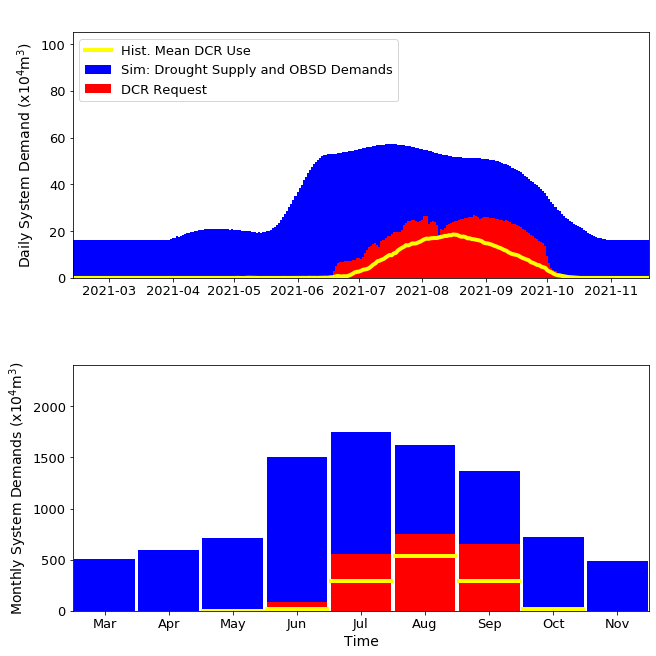

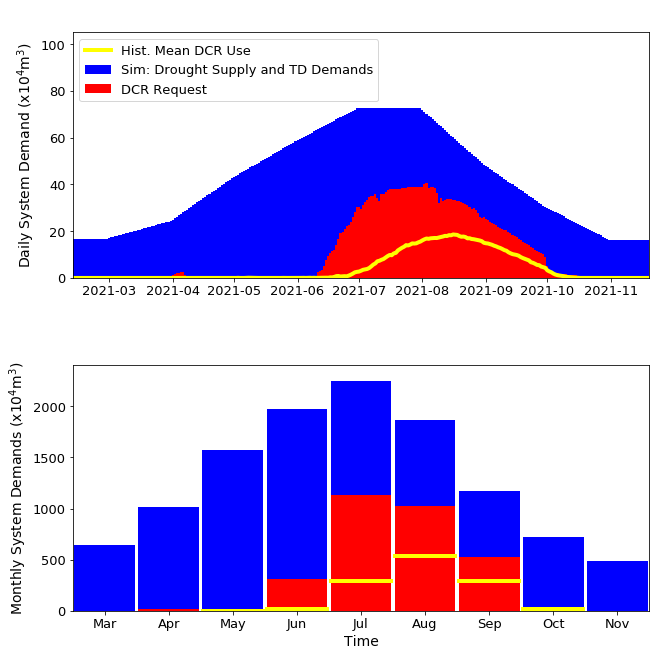

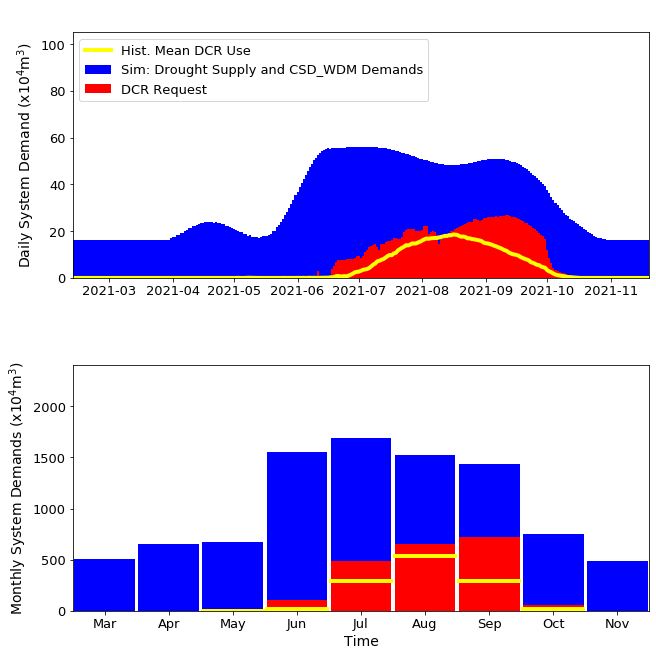

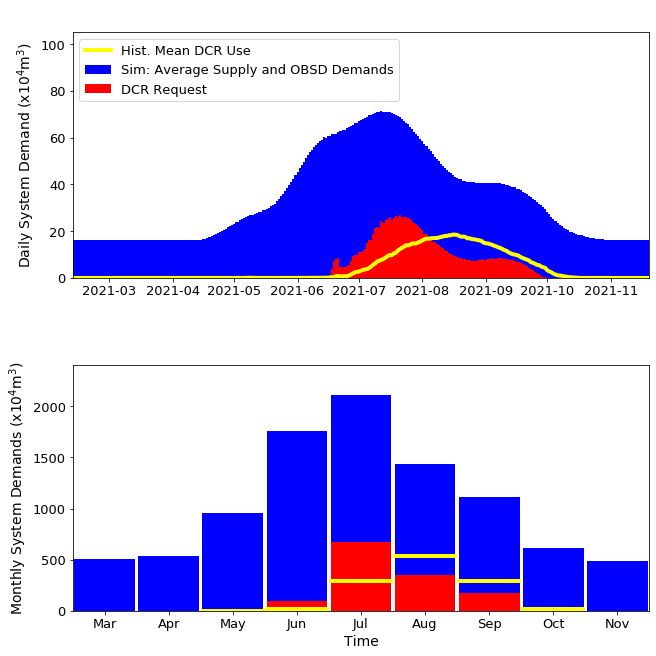

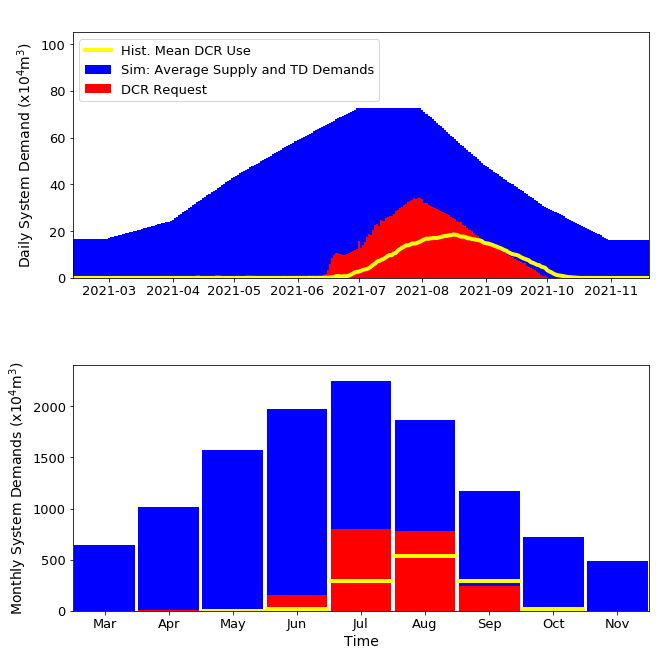

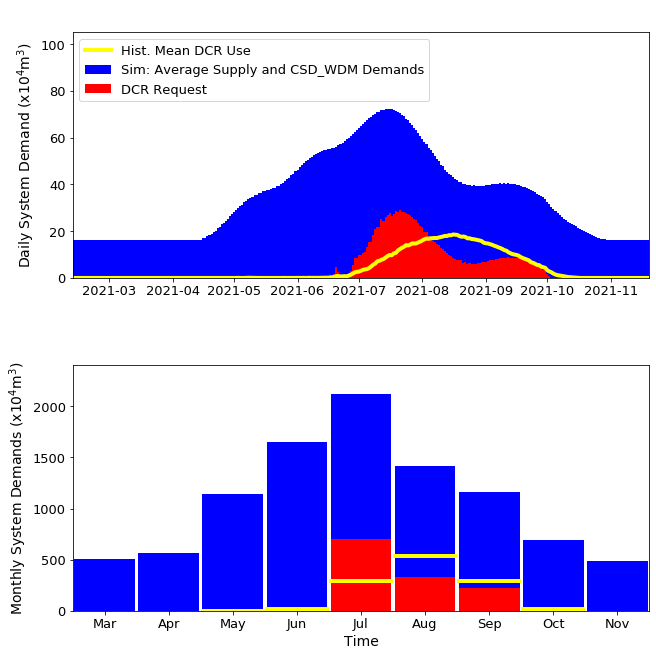

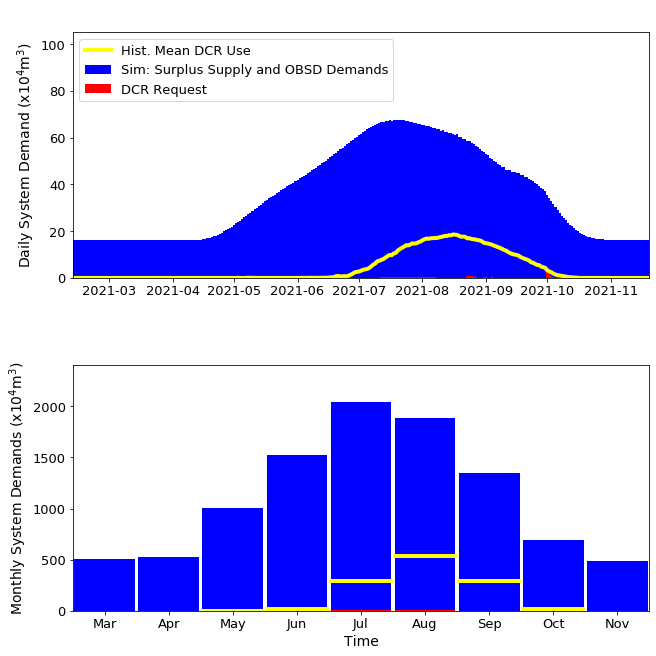

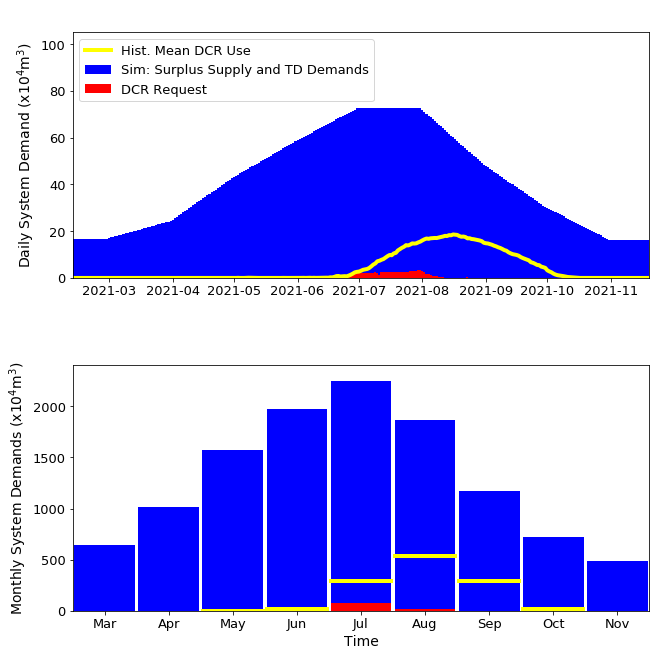

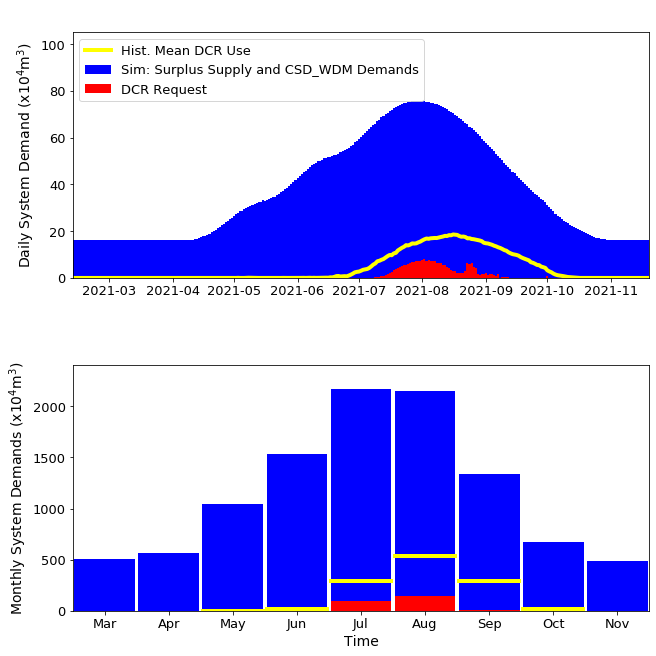

In [61]:
RRV_Assessment_D =pd.DataFrame(columns =['Climate', 'Demand', 'Reliability',
    'Resilience', 'Vulnerability', 'MaxSeverity', 'MaxSevSI', 'Maximum_Severity'])

RRV_Data_D =pd.DataFrame(columns = ['SLCDPU_Prod_Demands', 'SLCDPU_Shortages', 'SLCDPU_GW',
       'SLCDPU_Streamflow', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery',
       'Extra_DC', 'ExtraDC', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'])

RRV_Assessment_M =pd.DataFrame(columns =['Climate', 'Demand', 'Reliability',
    'Resilience', 'Vulnerability',  'MaxSeverity','MaxSevSI', 'Maximum_Severity'])

RRV_Data_M = pd.DataFrame(columns = ['SLCDPU_Prod_Demands', 'SLCDPU_Shortages', 'SLCDPU_GW',
       'SLCDPU_Streamflow', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery',
       'Extra_DC', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'])


sup = ['Drought', 'Average', 'Surplus']
Demands = ['OBSD', 'TD', 'CSD_WDM']


Indcons = 0
Outcons = 0
maxseverity = 1

for i in sup:
    for d in Demands:

        #SysSim = Clim_Scenario+'_Ind'+str(Indcons)+'_Out'+str(Outcons) 
        #replace MLR with F for fixed/stationary demands
        SysSim = i + '_S_'+d+'_Ind0_Out0'
        #DellSim = Clim_Scenario+'_Dell_Ind'+str(Indcons)+'_Out'+str(Outcons)   
        DellSim = i + '_S_OBSD_Dell'
        #modeltype = 'Modeled '+sup+ ' Demand'
        modeltype = d
        Clim_Scenario = i +' Supply and '+ d +' Demands'



        Daily2021, Monthly2021, Dell2021 = ForecastDataPrep(GSResults[SysSim], GSResults['Average_S_OBSD_Ind0_Out0'],
                                                                2021, GSResults[DellSim], Clim_Scenario)

        #Sup_Dem_Figure(DayDF, MonthDF, Dell, yr, IndoorCons, OutdoorCons, FigPath, simulation):
        #Sup_Dem_Figure(Output2021, MonthlySum2021, Dell2021, 2021,Indcons, Outcons, FigPath, Clim_Scenario, modeltype)
        Sup_Dem_Figure2(Daily2021, Monthly2021, Dell2021, 2021,Indcons, Outcons, FigPath, Clim_Scenario, modeltype)


        Rel_D, Res_D, Vul_D, Daily2021RRV,Max_Severity,MaxSevSI, MaxSevNorm = RRV(Daily2021, i, d, Historical_Max_Daily_DC, 'Daily', 2021)
        print('For Daily scenario ', Clim_Scenario)
        print('Reliability: ', Rel_D, 'Resilience: ', Res_D, 'Vulnerability: ', Vul_D)
        RRVass_D = list([i, d, Rel_D, Res_D, Vul_D, Max_Severity,MaxSevSI, MaxSevNorm])
        RRV_Assessment_D.loc[len(RRV_Assessment_D)] = RRVass_D
        RRV_Data_D = RRV_Data_D.append(Daily2021RRV)
        
        Rel_M, Res_M, Vul_M, Monthly2021RRV, Max_Severity,MaxSevSI, MaxSevNorm = RRV(Monthly2021, i, d, Historical_Max_Monthly_DC, 'Monthly', 2021)
        print('For Monthly scenario ', Clim_Scenario)
        print('Reliability: ', Rel_M, 'Resilience: ', Res_M, 'Vulnerability: ', Vul_M)
        RRVass_M = list([i, d, Rel_M, Res_M, Vul_M, Max_Severity,MaxSevSI, MaxSevNorm])
        RRV_Assessment_M.loc[len(RRV_Assessment_M)] = RRVass_M
        RRV_Data_M = RRV_Data_M.append(Monthly2021RRV)
        RRV_Data_M['AveT_Demands'] = MaveDemandT
        RRV_Data_M['AveT_Stream'] = MaveStreamT
        RRV_Data_M['Perc_Demand'] = ((RRV_Data_M['SLCDPU_Prod_Demands']-RRV_Data_M['AveT_Demands'])/RRV_Data_M['AveT_Demands'])*100
        RRV_Data_M['Perc_Stream'] = ((RRV_Data_M['SLCDPU_Streamflow']-RRV_Data_M['AveT_Stream'])/RRV_Data_M['AveT_Stream'])*100
        


In [62]:
#need to add to the historical RRV assessments to determine breaks
years =  [2001,2002,2003,2004, 2005, 2006, 2007,2008, 2009, 2010,
          2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,2020]
Clim_Scenario = 'Historical'
modeltype = 'Obs'
for y in years:
    HistDay = Hist.loc[str(y)+'-01-01':str(y)+'-12-31'].copy()
    HistMonth = HistM.loc[str(y)+'-01-01':str(y)+'-12-31'].copy()
    HistMonth.index =  pd.to_datetime(HistMonth.index, format='%m').month_name().str.slice(stop=3)
    Rel_D, Res_D, Vul_D, DailyRRV,Max_Severity,MaxSevSI, MaxSevNorm = RRV(HistDay, 'Hist', 'OBSD', Historical_Max_Daily_DC, 'Daily',y)
    print('For Daily scenario ', Clim_Scenario)
    print('Reliability: ', Rel_D, 'Resilience: ', Res_D, 'Vulnerability: ', Vul_D)
    RRVass_D = list(['Hist', 'OBSD', Rel_D, Res_D, Vul_D, Max_Severity,MaxSevSI, MaxSevNorm])
    RRV_Assessment_D.loc[len(RRV_Assessment_D)] = RRVass_D
    RRV_Data_D = RRV_Data_D.append(DailyRRV)

    Rel_M, Res_M, Vul_M, MonthlyRRV, Max_Severity,MaxSevSI, MaxSevNorm = RRV(HistMonth, 'Hist', 'OBSD', Historical_Max_Monthly_DC, 'Monthly',y)
    print('For Monthly scenario ', Clim_Scenario)
    print('Reliability: ', Rel_M, 'Resilience: ', Res_M, 'Vulnerability: ', Vul_M)
    RRVass_M = list(['Hist', 'OBSD', Rel_M, Res_M, Vul_M, Max_Severity,MaxSevSI, MaxSevNorm])
    RRV_Assessment_M.loc[len(RRV_Assessment_M)] = RRVass_M
    #RRV_Data_M = RRV_Data_M.append(MonthlyRRV)
    RRV_Data_M['AveT_Demands'] = MaveDemandT
    RRV_Data_M['AveT_Stream'] = MaveStreamT
    RRV_Data_M['Perc_Demand'] = ((RRV_Data_M['SLCDPU_Prod_Demands']-RRV_Data_M['AveT_Demands'])/RRV_Data_M['AveT_Demands'])*100
    RRV_Data_M['Perc_Stream'] = ((RRV_Data_M['SLCDPU_Streamflow']-RRV_Data_M['AveT_Stream'])/RRV_Data_M['AveT_Stream'])*100


Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For Daily scenario  Historical
Reliability:  0.6074766355140186 Resilience:  42.5 Vulnerability:  0.3540292966762114
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Time', 'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity',
       'Vulnerability'],
      dtype='object')
For Monthly scenario  Historical
Reliability:  0.42857142857142855 Resilience:  5.0 Vulnerability:  0.39853556357413344
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
F

Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For Daily scenario  Historical
Reliability:  0.6915887850467289 Resilience:  13.4 Vulnerability:  0.3693503133472828
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Time', 'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity',
       'Vulnerability'],
      dtype='object')
For Monthly scenario  Historical
Reliability:  0.5714285714285714 Resilience:  4.0 Vulnerability:  0.3685815199453191
Index(['SLCDPU_Prod_Demands', 'SLCDPU_Streamflow', 'SLCDPU_Shortages',
       'SLCDPU_GW', 'SLCDPU_DC_Water_Use', 'Hist_Mean_DC_Delivery', 'Extra_DC',
       'Clim', 'Demand', 'Zt', 'Wt', 'WRI_s', 'Severity', 'Vulnerability'],
      dtype='object')
For

[0.0014026440479695714, 0.07597861357876862, 0.31202471279291555, 0.45973318872781965, 0.5985406320599944]
[0.0, 0.199794424083689, 0.4978207962815434, 0.7521430618825128, 1.0]
Historical Reliability, Resilience, Vulnerability, Peak Seveirty 0.6285714285714288 3.025 0.2833441423206283 0.2911543430220024
[0.004377852558287952, 0.12406625153056547, 0.28679995834729927, 0.4890147230600157, 0.650981189307284]
[0.0, 0.07632827251903576, 0.3766759155474926, 0.6710861578431737, 1.0]
Historical Reliability, Resilience, Vulnerability, Peak Seveirty 0.6285714285714288 3.025 0.2833441423206283 0.2911543430220024


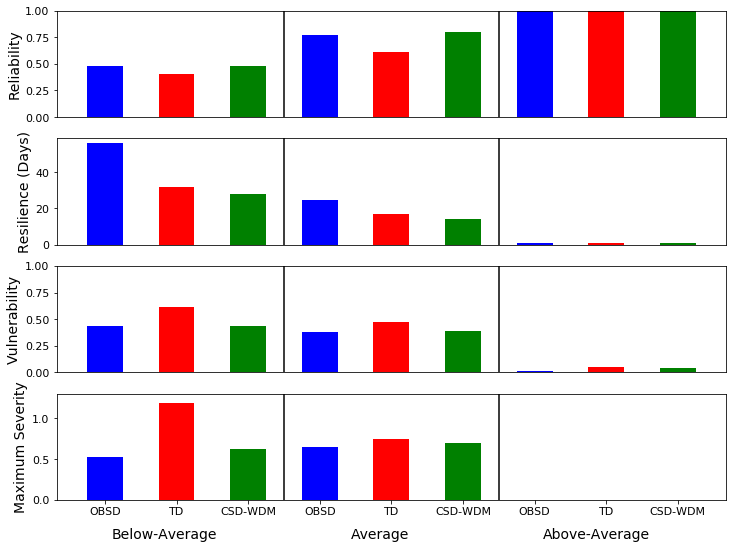

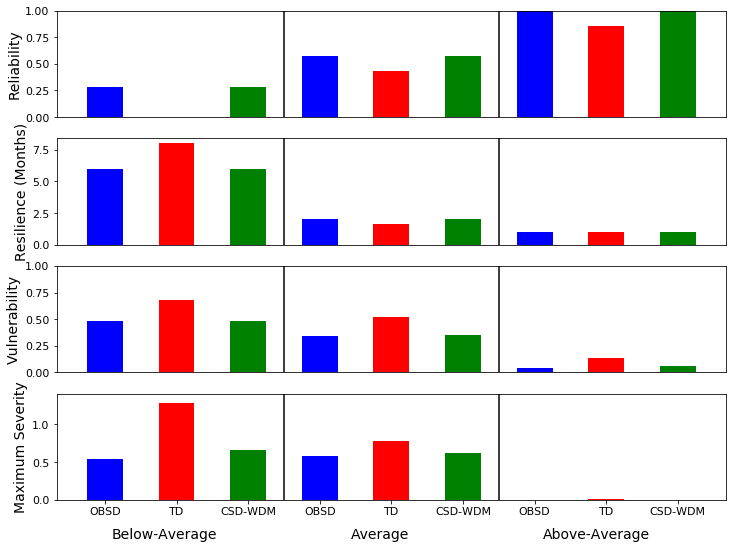

In [63]:
RRV_Assessment_D = RRVanalysis(RRV_Assessment_D, 'Days')
RRV_Assessment_M = RRVanalysis(RRV_Assessment_M, 'Months')

In [64]:
RRV_Assessment_D[:9]

,Climate,Demand,Reliability,Resilience,Vulnerability,MaxSeverity,MaxSevSI,Maximum_Severity,Jenks_VCatAve,Jenks_VCatPeak,Perc_Rel_Hist,Perc_Res_Hist,Perc_Vul_Hist,Perc_MSev_Hist
0,Drought,OBSD,0.481308,56.000000,0.435950,13.380264,13.380264,0.521345,high,high,-23.428207,-1751.239669,53.858801,79.061269
1,Drought,TD,0.406542,32.000000,0.615886,30.452075,30.452075,1.186526,NaN,NaN,-35.322855,-957.851240,117.363210,307.524647
2,Drought,CSD_WDM,0.481308,28.000000,0.437628,16.111198,16.111198,0.627752,high,high,-23.428207,-825.619835,54.451057,115.607971
3,Average,OBSD,0.775701,24.500000,0.376342,16.669576,16.669576,0.649508,high,high,23.406967,-709.917355,32.821530,123.080466
4,Average,TD,0.607477,17.000000,0.475051,19.314303,19.314303,0.752557,very_high,very_high,-3.355990,-461.983471,67.658806,158.473508
5,Average,CSD_WDM,0.803738,14.333333,0.391728,17.803265,17.803265,0.693681,high,high,27.867460,-373.829201,38.251687,138.252053
6,Surplus,OBSD,1.000000,1.000000,0.008762,0.000000,0.000000,0.000000,low,low,59.090909,66.942149,-96.907756,-100.000000
7,Surplus,TD,1.000000,1.000000,0.051216,0.000000,0.000000,0.000000,low,low,59.090909,66.942149,-81.924340,-100.000000
8,Surplus,CSD_WDM,1.000000,1.000000,0.038201,0.000000,0.000000,0.000000,low,low,59.090909,66.942149,-86.517718,-100.000000


In [65]:
RRV_Assessment_M[:9]

,Climate,Demand,Reliability,Resilience,Vulnerability,MaxSeverity,MaxSevSI,Maximum_Severity,Jenks_VCatAve,Jenks_VCatPeak,Perc_Rel_Hist,Perc_Res_Hist,Perc_Vul_Hist,Perc_MSev_Hist
0,Drought,OBSD,0.285714,6.000000,0.485915,356.637453,356.637453,0.546702,high,high,-54.545455,-98.347107,71.492697,87.770480
1,Drought,TD,0.000000,8.000000,0.678850,832.778481,832.778481,1.276595,NaN,NaN,-100.000000,-164.462810,139.584992,338.459882
2,Drought,CSD_WDM,0.285714,6.000000,0.479630,427.673566,427.673566,0.655596,high,high,-54.545455,-98.347107,69.274707,125.171166
3,Average,OBSD,0.571429,2.000000,0.338945,379.354933,379.354933,0.581526,high,high,-9.090909,33.884298,19.622931,99.731289
4,Average,TD,0.428571,1.666667,0.517107,503.389981,503.389981,0.771664,very_high,very_high,-31.818182,44.903581,82.501257,165.036041
5,Average,CSD_WDM,0.571429,2.000000,0.352723,404.445150,404.445150,0.619988,high,high,-9.090909,33.884298,24.485649,112.941348
6,Surplus,OBSD,1.000000,1.000000,0.037374,0.000000,0.000000,0.000000,low,low,59.090909,66.942149,-86.809545,-100.000000
7,Surplus,TD,0.857143,1.000000,0.137147,6.324331,6.324331,0.009695,medium,low,36.363636,66.942149,-51.596972,-96.670224
8,Surplus,CSD_WDM,1.000000,1.000000,0.059644,0.000000,0.000000,0.000000,low,low,59.090909,66.942149,-78.950091,-100.000000


In [104]:
x = RRV_Data_D[(RRV_Data_D['Clim']=='Surplus') & (RRV_Data_D['Demand']=='TD')]
x[x['ExtraDC']>.4]

,SLCDPU_Prod_Demands,SLCDPU_Shortages,SLCDPU_GW,SLCDPU_Streamflow,SLCDPU_DC_Water_Use,Hist_Mean_DC_Delivery,Extra_DC,ExtraDC,Zt,Wt,WRI_s,Severity,Vulnerability,Clim,Demand
2021-06-11,63.585894,0.0,11.038413,232.140936,0.864793,0.055244,0.0,0.809549,1,0,0.819519,0.0,0.409760,Surplus,TD
2021-06-24,69.679285,0.0,11.038413,344.881008,1.180070,0.765619,0.0,0.414451,1,0,0.668361,0.0,0.334180,Surplus,TD
2021-06-25,70.148008,0.0,11.038413,350.061624,1.428370,0.701795,0.0,0.726575,1,0,0.839331,0.0,0.419666,Surplus,TD
2021-06-26,70.616730,0.0,11.038413,323.418456,1.677533,1.005572,0.0,0.671961,1,0,0.836436,0.0,0.418218,Surplus,TD
2021-06-27,71.085452,0.0,11.038413,314.414052,1.848987,1.380498,0.0,0.468489,1,0,0.776723,0.0,0.388361,Surplus,TD


In [151]:
MaveStreamT = HistMonthly['SLCDPU_Streamflow']
MaveDemandT = HistMonthly['SLCDPU_Prod_Demands']
MaveDC = HistMonthly['SLCDPU_DC_Water_Use']
MaveExtraDC = HistMonthly['Extra_DC']
SeasonExtraDC = MaveExtraDC.sum()

NonRRVassessment =pd.DataFrame(columns =['Climate', 'Demand','DCmaxD', 'maxDemD','maxDemM', 'DCextraD', 'DCextraM', 'DCmaxDate', 'DCAAmax', 'DCAAmaxDate',
                        'DCmaxM','DCmaxMonth','DCAAmaxM','DCAAmaxMonth','MaxPercHist_DM', 'MaxPercHist_StrmM', 'SeasonD', 'SeasonDR', 
                        'SeasonD_Perc','SeasonDC', 'SeasonDC_Perc','SeasonDCextra', 'SeasonDCextra_Perc', 'SeasonStrm', 
                                         'SeasonStrm_Perc', 'SeasonStrmRatio'])


for s in sup:
    for d in Demands:    
        x = RRV_Data_D.loc[(RRV_Data_D['Clim']== s) & (RRV_Data_D['Demand']==d)]
        y = RRV_Data_M.loc[(RRV_Data_M['Clim']== s) & (RRV_Data_M['Demand']==d)]
        #x.loc['2021-06-15':'2021-07-30']
        #number of days of extra DC water
        DCextraD = len(x.loc[x['Extra_DC']> 0])
        DCextraM = len(y.loc[y['Extra_DC']> 0])
        #max slcdpu demand
        maxDemD = x['SLCDPU_Prod_Demands'].max()
        
        #Max Day
        DCmaxD = x['SLCDPU_DC_Water_Use'].max()
        DCmaxDate = x.loc[x['SLCDPU_DC_Water_Use']==DCmaxD].index
        DCmaxDate = DCmaxDate.format('%Y-%m-%d')[1]
        #DC above average max
        DCAAmax = x['Extra_DC'].max()
        DCAAmaxDate = x.loc[x['Extra_DC']==DCAAmax].index
        DCAAmaxDate = DCAAmaxDate.format('%Y-%m-%d')[1]
        DCAAmax = DCAAmax
        
        #peak month
        maxDemM = y['SLCDPU_Prod_Demands'].max()
        DCmaxM = y['SLCDPU_DC_Water_Use'].max()
        DCmaxMonth = y.loc[y['SLCDPU_DC_Water_Use']==DCmaxM].index
        DCmaxM = DCmaxM
        DCmaxMonth = DCmaxMonth.format('%Y-%m-%d')[1]
        
        #DC above aveage month
        DCAAmaxM = y['Extra_DC'].max()
        DCAAmaxMonth = y.loc[y['Extra_DC']==DCAAmaxM].index
        DCAAmaxMonth = DCAAmaxMonth.format('%Y-%m-%d')[1]
        DCAAmaxM =DCAAmaxM
        
        #Find the max percentage of historical monthly demand
        y['Hist_Mean_Demand_M']= MaveDemandT[3:10].values
        y['PercHist_DM'] = ((y['SLCDPU_Prod_Demands']-y['Hist_Mean_Demand_M'])/y['Hist_Mean_Demand_M'])*100
        MaxPercHist_DM = max(y['PercHist_DM'])
        
        #Find the max percentage of historical monthly streamflow
        y['Hist_Mean_Strm_M']= MaveStreamT[3:10].values
        y['PercHist_StrmM'] = ((y['SLCDPU_Streamflow']-y['Hist_Mean_Strm_M'])/y['Hist_Mean_Strm_M'])*100
        MaxPercHist_StrmM = max(y['PercHist_StrmM'])
        
        #Find the total season demands
        SeasonD = y['SLCDPU_Prod_Demands'].sum()
        SeasonD_Perc = ((SeasonD-SeasAveDemand)/SeasAveDemand)*100
        SeasonDR =SeasonD/SeasAveDemand
        
        SeasonDC = y['SLCDPU_DC_Water_Use'].sum()
        SeasonDC_Perc = ((SeasonDC-SeasAveDC)/SeasAveDC)*100
        SeasonDC = SeasonDC
        
        SeasonDCextra = y['Extra_DC'].sum()
        SeasonDCextra_Perc = ((SeasonDCextra-SeasonExtraDC)/SeasonExtraDC)*100
        SeasonDCextra = SeasonDCextra
        
        SeasonStrm = y['SLCDPU_Streamflow'].sum()
        SeasonStrm_Perc = ((SeasonStrm-SeasAveStream)/SeasAveStream)*100
        SeasonStrmRatio = ((SeasonStrm)/SeasAveStream)
        
        
        SimStats =list([s, d,DCmaxD, maxDemD,maxDemM, DCextraD, DCextraM, DCmaxDate, DCAAmax, DCAAmaxDate,DCmaxM,  DCmaxMonth,
                         DCAAmaxM,DCAAmaxMonth,MaxPercHist_DM, MaxPercHist_StrmM, SeasonD,SeasonDR, SeasonD_Perc,
                        SeasonDC, SeasonDC_Perc,SeasonDCextra, SeasonDCextra_Perc, SeasonStrm, SeasonStrm_Perc, SeasonStrmRatio])
        
        #print(SimStats)
        NonRRVassessment.loc[len(NonRRVassessment)] = SimStats

<ipython-input-151-4d3a2cd4abf4>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Hist_Mean_Demand_M']= MaveDemandT[3:10].values
<ipython-input-151-4d3a2cd4abf4>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['PercHist_DM'] = ((y['SLCDPU_Prod_Demands']-y['Hist_Mean_Demand_M'])/y['Hist_Mean_Demand_M'])*100
<ipython-input-151-4d3a2cd4abf4>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [154]:
#columns =['Climate', 'Demand', 'DCmaxD', 'maxDemD','maxDemM', 'DCextraD', 'DCextraM', 'DCmaxDate', 'DCAAmax', 'DCAAmaxDate',
                #        'DCmaxM','DCmaxMonth','DCAAmaxM','DCAAmaxMonth']
NonRRVassessment

,Climate,Demand,DCmaxD,maxDemD,maxDemM,DCextraD,DCextraM,DCmaxDate,DCAAmax,DCAAmaxDate,...,SeasonD,SeasonDR,SeasonD_Perc,SeasonDC,SeasonDC_Perc,SeasonDCextra,SeasonDCextra_Perc,SeasonStrm,SeasonStrm_Perc,SeasonStrmRatio
0,Drought,OBSD,26.889864,57.245807,1749.160984,111,5,2021-08-26,13.380264,2021-09-12,...,8260.442873,1.026502,2.650238,2077.568545,88.588828,924.189095,151.690576,4962.704489,-47.382566,0.526174
1,Drought,TD,40.433474,72.577963,2248.683379,127,7,2021-08-03,30.452075,2021-07-06,...,10566.174702,1.313029,31.302930,3042.509877,176.180237,1888.429227,414.288519,4962.704489,-47.382566,0.526174
2,Drought,CSD_WDM,26.902199,56.086336,1689.053503,111,5,2021-09-11,16.111198,2021-09-15,...,8271.803224,1.027914,2.791410,2026.220081,83.927732,878.167552,139.157223,4962.704489,-47.382566,0.526174
3,Average,OBSD,26.766516,71.258140,2105.427012,48,3,2021-07-21,16.669576,2021-07-12,...,8519.337990,1.058675,5.867456,1296.591066,17.696521,465.591116,26.797532,5869.620659,-37.766921,0.622331
4,Average,TD,34.105722,72.577963,2248.683379,84,4,2021-07-30,19.314303,2021-07-28,...,10566.174702,1.313029,31.302930,1988.278088,80.483593,901.317137,145.461704,5869.620659,-37.766921,0.622331
5,Average,CSD_WDM,28.912771,72.269593,2121.980314,42,3,2021-07-21,17.803265,2021-07-19,...,8748.432230,1.087143,8.714347,1295.975176,17.640614,442.641101,20.547402,5869.620659,-37.766921,0.622331
6,Surplus,OBSD,2.547136,67.693382,2042.901911,0,0,2021-10-01,0.000000,2021-04-01,...,9026.409283,1.121687,12.168691,27.376469,-97.514933,0.000000,-100.000000,19895.625352,110.944811,2.109448
7,Surplus,TD,3.330396,72.577963,2248.683379,0,1,2021-07-31,0.000000,2021-04-01,...,10566.174702,1.313029,31.302930,113.250016,-89.719864,6.324331,-98.277653,19895.625352,110.944811,2.109448
8,Surplus,CSD_WDM,7.925109,75.797346,2168.198809,0,0,2021-08-02,0.000000,2021-04-01,...,9467.427722,1.176491,17.649105,250.082696,-77.299039,0.000000,-100.000000,19895.625352,110.944811,2.109448


In [146]:
def Sensitivity(df1, df2):
    df = pd.concat([df1, df2], axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    DemVarDrought = df[df['Climate'] == 'Drought'].copy()
    DemVarAve = df[df['Climate'] == 'Average'].copy()
    DemVarSurplus = df[df['Climate'] == 'Surplus'].copy()
    
    SupVarObs = df[df['Demand'] == 'OBSD'].copy()
    SupVarTrad = df[df['Demand'] == 'TD'].copy()
    SupVarCSD = df[df['Demand'] == 'CSD_WDM'].copy()
    
    Demands = [DemVarDrought, DemVarAve, DemVarSurplus]
    Supply = [SupVarObs, SupVarTrad, SupVarCSD]
    
    RelRange_D = []
    ResRange_D = []
    AVRange_D = []
    PSRange_D = []
    
    #for Demand
    for i in Demands:
        Rel = (max(i['Reliability'])-min(i['Reliability']))/(max(i['SeasonDR'])-min(i['SeasonDR']))
        Res = (max(i['Resilience'])-min(i['Resilience']))/(max(i['SeasonDR'])-min(i['SeasonDR']))
        AV = (max(i['Vulnerability'])-min(i['Vulnerability']))/(max(i['SeasonDR'])-min(i['SeasonDR']))
        PS = (max(i['Maximum_Severity'])-min(i['Maximum_Severity']))/(max(i['SeasonDR'])-min(i['SeasonDR']))
        RelRange_D.append(Rel)
        ResRange_D.append(Res)
        AVRange_D.append(AV)
        PSRange_D.append(PS)
        
        
    RelRange_S = []
    ResRange_S = []
    AVRange_S = []
    PSRange_S = []
    
    #for Supply
    for i in Supply:
        Rel = (max(i['Reliability'])-min(i['Reliability']))/(max(i['SeasonStrmRatio'])-min(i['SeasonStrmRatio']))
        Res = (max(i['Resilience'])-min(i['Resilience']))/(max(i['SeasonStrmRatio'])-min(i['SeasonStrmRatio']))
        AV = (max(i['Vulnerability'])-min(i['Vulnerability']))/(max(i['SeasonStrmRatio'])-min(i['SeasonStrmRatio']))
        PS = (max(i['Maximum_Severity'])-min(i['Maximum_Severity']))/(max(i['SeasonStrmRatio'])-min(i['SeasonStrmRatio']))
        RelRange_S.append(Rel)
        ResRange_S.append(Res)
        AVRange_S.append(AV)
        PSRange_S.append(PS)
    
    DemandSensitivity = [max(RelRange_D), max(ResRange_D), max(AVRange_D), max(PSRange_D)]
    SupplySensitivity = [ max(RelRange_S),max(ResRange_S), max(AVRange_S),max(PSRange_S)] 
    
    SensitivityDF = pd.DataFrame(columns=['Metric', 'Demand', 'Supply'])
    SensitivityDF['Metric'] = ['Reliability', 'Resilience', 'Vulnerability', 'Severity']
    SensitivityDF['Demand'] = DemandSensitivity
    SensitivityDF['Supply'] = SupplySensitivity
    return SensitivityDF
    
    
    

In [147]:
SensitivityDay = Sensitivity(RRV_Assessment_D[:9], NonRRVassessment)
SensitivityMonth = Sensitivity(RRV_Assessment_M[:9], NonRRVassessment)


In [148]:
SensitivityDay

,Metric,Demand,Supply
0,Reliability,0.771606,0.374830
1,Resilience,97.722058,34.738149
2,Vulnerability,0.627990,0.356647
3,Severity,2.321531,0.749413


In [149]:
SensitivityMonth

,Metric,Demand,Supply
0,Reliability,0.997164,0.541374
1,Resilience,6.980147,4.421219
2,Vulnerability,0.700447,0.342141
3,Severity,2.547381,0.800178


In [105]:
sum(MaveDC[3:10])

1153.7840257297516

In [106]:
SeasAveStream

9431.673248799998

In [41]:
OBS_Drought_Sim = GSResults['Drought_S_OBSD_Ind0_Out0']
FD_Drought_Sim = GSResults['Drought_S_FD_Ind0_Out0']
MLRD_Drought_Sim = GSResults['Drought_S_MLRD_Ind0_Out0']

OBS_Average_Sim = GSResults['Average_S_OBSD_Ind0_Out0']
FD_Average_Sim = GSResults['Average_S_FD_Ind0_Out0']
MLRD_Average_Sim = GSResults['Average_S_MLRD_Ind0_Out0']

OBS_Surplus_Sim = GSResults['Surplus_S_OBSD_Ind0_Out0']
FD_Surplus_Sim = GSResults['Surplus_S_FD_Ind0_Out0']
MLRD_Surplus_Sim = GSResults['Surplus_S_MLRD_Ind0_Out0']

In [42]:
OBS_Average_Sim[OBS_Average_Sim['Time']== '2021-07-30']

,Time,SLCDPU_Prod_Demands,SLCDPU_Streamflow,SLCDPU_Shortages,SLCDPU_GW,SLCDPU_DC_Water_Use
7607,2021-07-30,490.9,95.62,0.0,89.49,180.0


In [43]:
MLRD_Average_Sim[MLRD_Average_Sim['Time']== '2021-07-30']

,Time,SLCDPU_Prod_Demands,SLCDPU_Streamflow,SLCDPU_Shortages,SLCDPU_GW,SLCDPU_DC_Water_Use
7607,2021-07-30,502.2,95.62,0.0,89.49,191.3


In [44]:
FD_Average_Sim[FD_Average_Sim['Time']== '2021-07-30']

,Time,SLCDPU_Prod_Demands,SLCDPU_Streamflow,SLCDPU_Shortages,SLCDPU_GW,SLCDPU_DC_Water_Use
7607,2021-07-30,588.4,95.62,0.0,89.49,276.5


In [ ]:
(MonthlySum2021.SLCDPU_DC_Water_Use.sum()-MonthlySum2021.Hist_Mean_DC_Delivery.sum())/MonthlySum2021.Hist_Mean_DC_Delivery.sum()

In [ ]:
Output2021['PercentAboveDC'] =(Output2021['Extra_DC']/Output2021['Hist_Mean_DC_Delivery'])*100
Output2021.replace([np.inf, -np.inf], 0, inplace=True)

In [ ]:
Output2021.loc['2021-06-1':'2021-07-30']

In [ ]:
ExtraDays = Output2021[Output2021['Extra_DC']>1 ] 
len(ExtraDays)

In [ ]:
ExtraDays = Output2021[Output2021['Extra_DC']>30 ] 
ExtraDays

In [ ]:
ExtraDays = Output2021[Output2021['SLCDPU_DC_Water_Use']>140 ] 
ExtraDays

In [ ]:
ExtraDays = Output2021[Output2021['SLCDPU_Prod_Demands']>140 ] 
ExtraDays

In [ ]:
ExtraDays = Output2021[Output2021['Hist_Mean_DC_Delivery']>10] 
ExtraDays

In [ ]:
#Percent change from scenario obs
    RRV_Assessment['Perc_Rel_Scen'] = 0
    RRV_Assessment['Perc_Rel_Scen'].iloc[0] = ((RRV_Assessment['Reliability'].iloc[0]/RRV_Assessment['Reliability'].iloc[0])*100)-100
    RRV_Assessment['Perc_Rel_Scen'].iloc[1] = ((RRV_Assessment['Reliability'].iloc[1]/RRV_Assessment['Reliability'].iloc[0])*100)-100
    RRV_Assessment['Perc_Rel_Scen'].iloc[2] = ((RRV_Assessment['Reliability'].iloc[2]/RRV_Assessment['Reliability'].iloc[0])*100)-100

    RRV_Assessment['Perc_Rel_Scen'].iloc[3] = ((RRV_Assessment['Reliability'].iloc[3]/RRV_Assessment['Reliability'].iloc[3])*100)-100
    RRV_Assessment['Perc_Rel_Scen'].iloc[4] = ((RRV_Assessment['Reliability'].iloc[4]/RRV_Assessment['Reliability'].iloc[3])*100)-100
    RRV_Assessment['Perc_Rel_Scen'].iloc[5] = ((RRV_Assessment['Reliability'].iloc[5]/RRV_Assessment['Reliability'].iloc[3])*100)-100

    RRV_Assessment['Perc_Rel_Scen'].iloc[6] = ((RRV_Assessment['Reliability'].iloc[6]/RRV_Assessment['Reliability'].iloc[6])*100)-100
    RRV_Assessment['Perc_Rel_Scen'].iloc[7] = ((RRV_Assessment['Reliability'].iloc[7]/RRV_Assessment['Reliability'].iloc[6])*100)-100
    RRV_Assessment['Perc_Rel_Scen'].iloc[8] = ((RRV_Assessment['Reliability'].iloc[8]/RRV_Assessment['Reliability'].iloc[6])*100)-100


    RRV_Assessment['Perc_Res_Scen'] = 0
    RRV_Assessment['Perc_Res_Scen'].iloc[0] = ((RRV_Assessment['Resilience'].iloc[0]/RRV_Assessment['Resilience'].iloc[0])*100)-100
    RRV_Assessment['Perc_Res_Scen'].iloc[1] = ((RRV_Assessment['Resilience'].iloc[1]/RRV_Assessment['Resilience'].iloc[0])*100)-100
    RRV_Assessment['Perc_Res_Scen'].iloc[2] = ((RRV_Assessment['Resilience'].iloc[2]/RRV_Assessment['Resilience'].iloc[0])*100)-100

    RRV_Assessment['Perc_Res_Scen'].iloc[3] = ((RRV_Assessment['Resilience'].iloc[3]/RRV_Assessment['Resilience'].iloc[3])*100)-100
    RRV_Assessment['Perc_Res_Scen'].iloc[4] = ((RRV_Assessment['Resilience'].iloc[4]/RRV_Assessment['Resilience'].iloc[3])*100)-100
    RRV_Assessment['Perc_Res_Scen'].iloc[5] = ((RRV_Assessment['Resilience'].iloc[5]/RRV_Assessment['Resilience'].iloc[3])*100)-100

    RRV_Assessment['Perc_Res_Scen'].iloc[6] = ((RRV_Assessment['Resilience'].iloc[6]/RRV_Assessment['Resilience'].iloc[6])*100)-100
    RRV_Assessment['Perc_Res_Scen'].iloc[7] = ((RRV_Assessment['Resilience'].iloc[7]/RRV_Assessment['Resilience'].iloc[6])*100)-100
    RRV_Assessment['Perc_Res_Scen'].iloc[8] = ((RRV_Assessment['Resilience'].iloc[8]/RRV_Assessment['Resilience'].iloc[6])*100)-100


    RRV_Assessment['Perc_Vul_Scen'] = 0
    RRV_Assessment['Perc_Vul_Scen'].iloc[0] = ((RRV_Assessment['Vulnerability'].iloc[0]/RRV_Assessment['Vulnerability'].iloc[0])*100)-100
    RRV_Assessment['Perc_Vul_Scen'].iloc[1] = ((RRV_Assessment['Vulnerability'].iloc[1]/RRV_Assessment['Vulnerability'].iloc[0])*100)-100
    RRV_Assessment['Perc_Vul_Scen'].iloc[2] = ((RRV_Assessment['Vulnerability'].iloc[2]/RRV_Assessment['Vulnerability'].iloc[0])*100)-100

    RRV_Assessment['Perc_Vul_Scen'].iloc[3] = ((RRV_Assessment['Vulnerability'].iloc[3]/RRV_Assessment['Vulnerability'].iloc[3])*100)-100
    RRV_Assessment['Perc_Vul_Scen'].iloc[4] = ((RRV_Assessment['Vulnerability'].iloc[4]/RRV_Assessment['Vulnerability'].iloc[3])*100)-100
    RRV_Assessment['Perc_Vul_Scen'].iloc[5] = ((RRV_Assessment['Vulnerability'].iloc[5]/RRV_Assessment['Vulnerability'].iloc[3])*100)-100

    RRV_Assessment['Perc_Vul_Scen'].iloc[6] = ((RRV_Assessment['Vulnerability'].iloc[6]/RRV_Assessment['Vulnerability'].iloc[6])*100)-100
    RRV_Assessment['Perc_Vul_Scen'].iloc[7] = ((RRV_Assessment['Vulnerability'].iloc[7]/RRV_Assessment['Vulnerability'].iloc[6])*100)-100
    RRV_Assessment['Perc_Vul_Scen'].iloc[8] = ((RRV_Assessment['Vulnerability'].iloc[8]/RRV_Assessment['Vulnerability'].iloc[6])*100)-100

    
    RRV_Assessment['Perc_MSev_Scen'] = 0
    RRV_Assessment['Perc_MSev_Scen'].iloc[0] = ((RRV_Assessment['Maximum_Severity'].iloc[0]/RRV_Assessment['Maximum_Severity'].iloc[0])*100)-100
    RRV_Assessment['Perc_MSev_Scen'].iloc[1] = ((RRV_Assessment['Maximum_Severity'].iloc[1]/RRV_Assessment['Maximum_Severity'].iloc[0])*100)-100
    RRV_Assessment['Perc_MSev_Scen'].iloc[2] = ((RRV_Assessment['Maximum_Severity'].iloc[2]/RRV_Assessment['Maximum_Severity'].iloc[0])*100)-100

    RRV_Assessment['Perc_MSev_Scen'].iloc[3] = ((RRV_Assessment['Maximum_Severity'].iloc[3]/RRV_Assessment['Maximum_Severity'].iloc[3])*100)-100
    RRV_Assessment['Perc_MSev_Scen'].iloc[4] = ((RRV_Assessment['Maximum_Severity'].iloc[4]/RRV_Assessment['Maximum_Severity'].iloc[3])*100)-100
    RRV_Assessment['Perc_MSev_Scen'].iloc[5] = ((RRV_Assessment['Maximum_Severity'].iloc[5]/RRV_Assessment['Maximum_Severity'].iloc[3])*100)-100

    RRV_Assessment['Perc_MSev_Scen'].iloc[6] = ((RRV_Assessment['Maximum_Severity'].iloc[6]/RRV_Assessment['Maximum_Severity'].iloc[6])*100)-100
    RRV_Assessment['Perc_MSev_Scen'].iloc[7] = ((RRV_Assessment['Maximum_Severity'].iloc[7]/RRV_Assessment['Maximum_Severity'].iloc[6])*100)-100
    RRV_Assessment['Perc_MSev_Scen'].iloc[8] = ((RRV_Assessment['Maximum_Severity'].iloc[8]/RRV_Assessment['Maximum_Severity'].iloc[6])*100)-100

    

In [ ]:
#need to add to the historical RRV assessments to determine breaks
years =  [2001,2002,2003,2004, 2005, 2006, 2007,2008, 2009, 2010,
          2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,2020]
Clim_Scenario = 'Historical'
modeltype = 'Obs'
for y in years:
    Daily, Monthly, Dell = ForecastDataPrep(GSResults['Average_S_OBSD_Ind0_Out0'], GSResults['Average_S_OBSD_Ind0_Out0'],
                                                            y, GSResults['Average_S_OBSD_Dell'], Clim_Scenario)

    #Sup_Dem_Figure(DayDF, MonthDF, Dell, yr, IndoorCons, OutdoorCons, FigPath, simulation):
    #Sup_Dem_Figure(Output2021, MonthlySum2021, Dell2021, 2021,Indcons, Outcons, FigPath, Clim_Scenario, modeltype)
    # Sup_Dem_Figure2(Daily, Monthly, Dell, y,0, 0, FigPath, Clim_Scenario, modeltype)


    Rel_D, Res_D, Vul_D, DailyRRV,Max_Severity,MaxSevSI, MaxSevNorm = RRV(Daily, 'Hist', 'OBSD', Historical_Max_Daily_DC, 'Daily',y)
    print('For Daily scenario ', Clim_Scenario)
    print('Reliability: ', Rel_D, 'Resilience: ', Res_D, 'Vulnerability: ', Vul_D)
    RRVass_D = list(['Hist', 'OBSD', Rel_D, Res_D, Vul_D, Max_Severity,MaxSevSI, MaxSevNorm])
    RRV_Assessment_D.loc[len(RRV_Assessment_D)] = RRVass_D
    RRV_Data_D = RRV_Data_D.append(DailyRRV)

    Rel_M, Res_M, Vul_M, MonthlyRRV, Max_Severity,MaxSevSI, MaxSevNorm = RRV(Monthly, 'Hist', 'OBSD', Historical_Max_Monthly_DC, 'Monthly',y)
    print('For Monthly scenario ', Clim_Scenario)
    print('Reliability: ', Rel_M, 'Resilience: ', Res_M, 'Vulnerability: ', Vul_M)
    RRVass_M = list(['Hist', 'OBSD', Rel_M, Res_M, Vul_M, Max_Severity,MaxSevSI, MaxSevNorm])
    RRV_Assessment_M.loc[len(RRV_Assessment_M)] = RRVass_M
    #RRV_Data_M = RRV_Data_M.append(MonthlyRRV)
    RRV_Data_M['AveT_Demands'] = MaveDemandT
    RRV_Data_M['AveT_Stream'] = MaveStreamT
    RRV_Data_M['Perc_Demand'] = ((RRV_Data_M['SLCDPU_Prod_Demands']-RRV_Data_M['AveT_Demands'])/RRV_Data_M['AveT_Demands'])*100
    RRV_Data_M['Perc_Stream'] = ((RRV_Data_M['SLCDPU_Streamflow']-RRV_Data_M['AveT_Stream'])/RRV_Data_M['AveT_Stream'])*100
    
#print(RRV_Assessment_D)
#del RRV_Assessment_D['MaxSeverity']
#del RRV_Assessment_M['MaxSeverity']